In [47]:
from fastai.vision.all import *

## Get data and check samples

Download MNIST sample dataset with only numbers 3 and 7

In [149]:
path = untar_data(URLs.MNIST_SAMPLE)
print(path.ls())

train_path = path/'train'
valid_path = path/'valid'
print(train_path.ls())

train_path_3 = train_path/'3'
train_path_7 = train_path/'7'
valid_path_3 = valid_path/'3'
valid_path_7 = valid_path/'7'

train_len = len(train_path_3.ls()) + len(train_path_7.ls())
valid_len = len(valid_path_3.ls()) + len(valid_path_7.ls())
train_perc = train_len / (train_len + valid_len) * 100

print(f"Number of train samples: {train_len}")
print(f"Number of validation samples: {valid_len}")
print(f"Train percentage: {train_perc:.0f}%")

[Path('/Users/boris.tsarev/.fastai/data/mnist_sample/valid'), Path('/Users/boris.tsarev/.fastai/data/mnist_sample/labels.csv'), Path('/Users/boris.tsarev/.fastai/data/mnist_sample/train')]
[Path('/Users/boris.tsarev/.fastai/data/mnist_sample/train/7'), Path('/Users/boris.tsarev/.fastai/data/mnist_sample/train/3')]
Number of train samples: 12396
Number of validation samples: 2038
Train percentage: 86%


Show some examples using Python Imaging Library (PIL)

In [150]:
img_3 = Image.open(train_path_3.ls()[0])
img_3

In [151]:
img_7 = Image.open(train_path_7.ls()[0])
img_7

Show example using Pandas

In [152]:
img_3_t = tensor(img_3)
print(f"Image size: {img_3_t.shape[0]} x {img_3_t.shape[1]} = {img_3_t.numel()} pixels")

Image size: 28 x 28 = 784 pixels


In [153]:
img_3_t_part = img_3_t[4:24, 4:22]
img_3_part_df = pd.DataFrame(img_3_t_part)
img_3_part_df.style.set_properties(**{'font-size':'4pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,104,253,253,253,121,121,76,0,0,0,0,0,0
1,0,0,0,0,0,30,156,252,252,253,252,247,240,240,240,148,39,0
2,0,0,0,0,0,0,3,26,26,159,158,158,158,233,252,252,212,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,31,99,210,239,56
4,0,0,0,0,0,0,0,0,0,0,0,0,0,53,204,252,204,56
5,0,0,0,0,0,0,0,0,0,0,0,49,166,238,241,198,143,0
6,0,0,0,0,0,0,0,0,0,20,97,244,252,252,205,42,0,0
7,0,0,0,0,0,0,0,2,27,204,252,252,229,190,24,0,0,0
8,0,0,0,0,0,0,2,26,252,253,246,238,37,0,0,0,0,0
9,0,0,0,0,0,0,13,196,252,253,145,0,0,0,0,0,0,0


## 1st Approach - Pixel similarity

In [43]:
train_3_tensors = [tensor(Image.open(f)) for f in train_path_3.ls().sorted()]
train_7_tensors = [tensor(Image.open(f)) for f in train_path_7.ls().sorted()]

Show image in tensor form with fastai `show_image`

<Axes: >

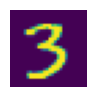

In [ ]:
show_image(train_3_tensors[1])

In [57]:
train_3_stacked = torch.stack(train_3_tensors).float() / 255
train_7_stacked = torch.stack(train_7_tensors).float() / 255
train_3_stacked.shape

torch.Size([6131, 28, 28])

<Axes: >

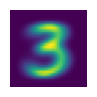

In [49]:
train_3_mean = train_3_stacked.mean(0)
show_image(train_3_mean)

<Axes: >

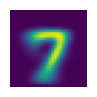

In [50]:
train_7_mean = train_7_stacked.mean(0)
show_image(train_7_mean)

Calculating similarity between number and ideal number by using:
- **MAE - L1 norm** - mean absolute value
- **MSE** - mean squared error
- **RMSE - L2 norm** - root mean squared error

MSE penalizes big mistakes more heavily

In [66]:
train_3_example = train_3_stacked[1]

In [67]:
dist_3_mav = (train_3_mean - train_3_example).abs().mean()
dist_3_rmse = ((train_3_mean - train_3_example)**2).mean().sqrt()
dist_3_mav, dist_3_rmse

(tensor(0.1114), tensor(0.2021))

In [68]:
dist_7_mav = (train_7_mean - train_3_example).abs().mean()
dist_7_rmse = ((train_7_mean - train_3_example)**2).mean().sqrt()
dist_7_mav, dist_7_rmse

(tensor(0.1586), tensor(0.3021))

Same with PyTourch

In [74]:
print(f"Diff from ideal 3: L1 {F.l1_loss(train_3_mean, train_3_example):.2f}, RMSE {F.mse_loss(train_3_mean, train_3_example).sqrt():.2f}")
print(f"Diff from ideal 7: L1 {F.l1_loss(train_7_mean, train_3_example):.2f}, RMSE {F.mse_loss(train_7_mean, train_3_example).sqrt():.2f}")

Diff from ideal 3: L1 0.11, RMSE 0.20
Diff from ideal 7: L1 0.16, RMSE 0.30


Calculate Model accuracy

In [77]:
valid_3_stacked = torch.stack([tensor(Image.open(f)) for f in valid_path_3.ls()]).float() / 255
valid_7_stacked = torch.stack([tensor(Image.open(f)) for f in valid_path_7.ls()]).float() / 255
valid_3_stacked.shape, valid_7_stacked.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [ ]:
def mnist_distance(a, b):
    return (a - b).abs().mean([-1, -2])

mnist_distance(train_3_example, train_3_mean)

tensor(0.1114)

In [81]:
valid_3_dist = mnist_distance(valid_3_stacked, train_3_mean)
valid_3_dist.shape

torch.Size([1010])

In [83]:
def is_3(x):
    return mnist_distance(x, train_3_mean) < mnist_distance(x, train_7_mean)

is_3(train_3_example)

tensor(True)

In [84]:
is_3(valid_3_stacked)

tensor([True, True, True,  ..., True, True, True])

In [87]:
accuracy_3s = is_3(valid_3_stacked).float().mean()
accuracy_7s = (1 - is_3(valid_7_stacked).float()).mean()
accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s) / 2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent - SGD

Prepare dataset: image (as vector) - label (1 for '3', 0 for '7')

In [90]:
train_x = torch.cat([train_3_stacked, train_7_stacked]).view(-1, 28 * 28)
train_y = tensor([1] * len(train_path_3.ls()) + [0] * len(train_path_7.ls())).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [93]:
train_dset = list(zip(train_x, train_y))
train_dset[0][0].shape, train_dset[0][1]

(torch.Size([784]), tensor([1]))

In [95]:
valid_x = torch.cat([valid_3_stacked, valid_7_stacked]).view(-1, 28 * 28)
valid_y = tensor([1] * len(valid_path_3.ls()) + [0] * len(valid_path_7.ls())).unsqueeze(1)
valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

In [96]:
valid_dset = list(zip(valid_x, valid_y))
valid_dset[0][0].shape, valid_dset[0][1]

(torch.Size([784]), tensor([1]))

Randomly initialize weights

In [ ]:
def init_params(size, std=1.0):
    return (torch.randn(size) * std).requires_grad_()

torch.Size([784, 1])

In [100]:
weigths = init_params((28 * 28, 1))
bias = init_params(1)
weigths.shape, bias.shape

(torch.Size([784, 1]), torch.Size([1]))

Check accuracy

In [101]:
def linear1(x):
    return x @ weigths + bias

In [103]:
pred = linear1(train_x)
pred

tensor([[ 1.7314],
        [-6.7729],
        [-7.2837],
        ...,
        [ 0.2756],
        [ 2.5398],
        [-3.4505]], grad_fn=<AddBackward0>)

In [107]:
corrects = (pred > 0.0).float() == train_y
corrects.float().mean()

tensor(0.5739)

Use Sigmoid for loss

In [114]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets == 1, 1 - predictions, predictions).mean()

DataLoader - class for working with mini-batches  
Dataset - collection of tuples of independent and dependent variables

In [116]:
# Example
ds = L(enumerate(string.ascii_lowercase))
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([21,  2, 12,  3, 20,  7]), ('v', 'c', 'm', 'd', 'u', 'h')),
 (tensor([ 5, 25, 11, 24, 17, 14]), ('f', 'z', 'l', 'y', 'r', 'o')),
 (tensor([22, 15, 16, 19, 10,  8]), ('w', 'p', 'q', 't', 'k', 'i')),
 (tensor([ 9, 23,  0, 18,  6,  4]), ('j', 'x', 'a', 's', 'g', 'e')),
 (tensor([13,  1]), ('n', 'b'))]

Putting it all together

In [118]:
weigths = init_params((28 * 28, 1))
bias = init_params(1)

In [122]:
train_dl = DataLoader(train_dset, batch_size = 256)
xb, yb = first(train_dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [123]:
valid_dl = DataLoader(valid_dset, batch_size = 256)

In [124]:
def calc_grad(x, y, model):
    pred = model(x)
    loss = mnist_loss(pred, y)
    loss.backward()

In [125]:
def train_epoch(model, lr, params):
    for x, y in train_dl:
        calc_grad(x, y, model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()

In [129]:
def batch_accuracy(x, y):
    pred = x.sigmoid()
    correct = (pred >= 0.5) == y
    return correct.float().mean()

In [130]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

Train 1 epoch

In [131]:
lr = 1.
params = weigths, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.7811

In [132]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.891 0.9217 0.9369 0.9432 0.9476 0.952 0.9554 0.9564 0.9578 0.9588 0.9593 0.9613 0.9618 0.9632 0.9642 0.9642 0.9647 0.9657 0.9662 0.9667 

Now with fastai

In [133]:
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [134]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636416,0.503652,0.495584,00:00
1,0.605225,0.090689,0.943572,00:00
2,0.218401,0.252848,0.763494,00:00
3,0.094492,0.124019,0.894995,00:00
4,0.048609,0.085504,0.926889,00:00
5,0.030744,0.066693,0.944553,00:00
6,0.023417,0.055474,0.953876,00:00
7,0.020197,0.048191,0.960255,00:00
8,0.018601,0.043167,0.964181,00:00
9,0.017672,0.039512,0.966634,00:00


Simple neural net

In [140]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,15))
b2 = init_params(15)
w2 = init_params((15,1))
b2 = init_params(1)

def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [142]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,15),
    nn.ReLU(),
    nn.Linear(15,1)
)

In [143]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [144]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.490747,0.453785,0.814524,00:00
1,0.294233,0.364147,0.582434,00:00
2,0.136354,0.181303,0.854269,00:00
3,0.070614,0.098711,0.922964,00:00
4,0.043316,0.070256,0.942100,00:00
5,0.031359,0.056208,0.954858,00:00
6,0.025698,0.047854,0.961727,00:00
7,0.022677,0.042406,0.964671,00:00
8,0.020809,0.038569,0.967125,00:00
9,0.019489,0.035705,0.969087,00:00


With good neural net

In [145]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.103949,0.014660,0.997056,00:18


## Deep learning vocabulary

| Term | Meaning |
|------|----------|
| **ReLU** | Function that returns 0 for negative numbers and doesn't change positive numbers. |
| **Mini-batch** | A small group of inputs and labels gathered together in two arrays. A gradient descent step is updated on this batch (rather than a whole epoch). |
| **Forward pass** | Applying the model to some input and computing the predictions. |
| **Loss** | A value that represents how well (or badly) our model is doing. |
| **Gradient** | The derivative of the loss with respect to some parameter of the model. |
| **Backward pass** | Computing the gradients of the loss with respect to all model parameters. |
| **Gradient descent** | Taking a step in the direction opposite to the gradients to make the model parameters a little bit better. |
| **Learning rate** | The size of the step we take when applying SGD to update the parameters of the model. |